In [1]:
# 12_clustering_audio_space.ipynb
# Clustering tracks in audio-feature space (KMeans, GMM, HDBSCAN)

from pathlib import Path
import sys
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Optional: HDBSCAN
try:
    import hdbscan
    HDBSCAN_AVAILABLE = True
    print("hdbscan is available.")
except ImportError:
    HDBSCAN_AVAILABLE = False
    print("hdbscan not installed. HDBSCAN section will be skipped.")

# Make src/ importable
PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)

DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
DATA_RAW = PROJECT_ROOT / "data" / "raw"

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


hdbscan is available.
PROJECT_ROOT: C:\Users\Kiera\Music_Recommender


In [2]:
# Combined audio feature dataset
combined_path = DATA_PROCESSED / "combined_features.csv"
feat_df_raw = pd.read_csv(combined_path)
feat_df_raw["track_id"] = feat_df_raw["track_id"].astype(str)

print("combined_features.csv shape:", feat_df_raw.shape)
feat_df_raw.head()


combined_features.csv shape: (4589288, 17)


,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,year,explicit,time_signature,popularity
0,0000QuApNltQzqS5ROXcQ7,0.629,0.199,4,-15.258,1,0.0610,0.9250,0.000000,0.1100,0.587,66.469,141813.0,2012.0,NaN,4.0,NaN
1,0000j9zugybaOxAeENtFRU,0.680,0.378,5,-7.379,1,0.0685,0.8850,0.000013,0.1200,0.963,116.877,112107.0,NaN,NaN,4.0,NaN
2,0000korRHja9p9XaR5UA5m,0.708,0.714,6,-7.579,1,0.0362,0.3970,0.000047,0.3540,0.756,120.538,235666.0,1995.0,NaN,4.0,NaN
3,0000uJA4xCdxThagdLkkLR,0.458,0.591,5,-5.621,1,0.0326,0.5680,0.000015,0.2860,0.654,184.913,161187.0,NaN,NaN,3.0,NaN
4,00018DRtkxXS7SmAG4ciN6,0.456,0.324,8,-11.521,1,0.0342,0.0242,0.596000,0.0868,0.522,184.970,238827.0,NaN,NaN,3.0,NaN


In [3]:
# Track metadata from MPD
meta_path = DATA_PROCESSED / "track_metadata.csv"
meta_df = pd.read_csv(meta_path)
meta_df["track_id"] = meta_df["track_id"].astype(str)

print("track_metadata.csv shape:", meta_df.shape)
meta_df.head()


track_metadata.csv shape: (679889, 7)


,track_id,track_name,artist_name,album_name,artist_uri,album_uri,duration_ms
0,0000uJA4xCdxThagdLkkLR,Heart As Cold As Stone,Cherryholmes,Cherryholmes,spotify:artist:5kEVfWQGTw0rIDO2Jqq1ww,spotify:album:3SPMBGMEvPw21lmT5b1ApW,161186
1,00039MgrmLoIzSpuYKurn9,Thas What I Do,Zach Farlow,The Great Escape 2,spotify:artist:2jTojc4rAsOMx6200a8Ah1,spotify:album:0UHfgx3ITlxePDXLaN5Y6x,222727
2,0005w1bMJ7QAMl6DY98oxa,"Sonata in G Major, BuxWV 271: Allegro -",Dietrich Buxtehude,"Chamber Music: London Baroque - Rosenmuller, J...",spotify:artist:2YfFYZnshSzgfLsKZMM4VL,spotify:album:6oRWciCAwKegipcCc5FlWe,111573
3,0007AYhg2UQbEm88mxu7js,Mandarin Oranges Part 2,Little Simz,E.D.G.E,spotify:artist:6eXZu6O7nAUA5z6vLV8NKI,spotify:album:32RJzqlapfiU0fr2l4SSW9,198000
4,000CTwOSsvRs0bgXlwB64e,Shady World,Celly Cel,The Lost Tapes,spotify:artist:6k7TX5dxiKZiwMWTn8ZKbl,spotify:album:6LOmO9x8uPwlc3gSXZqqi8,155238


In [4]:
# Interactions (for later evaluation / sanity checks if needed)
interactions_path = DATA_PROCESSED / "interactions.parquet"
interactions = pd.read_parquet(interactions_path)
interactions["track_id"] = interactions["track_id"].astype(str)

print("interactions.parquet shape:", interactions.shape)
interactions.head()


interactions.parquet shape: (6685101, 4)


,pid,track_id,pos,duration_ms
0,0,0UaMYEvWZi0ZqiDOoHU3YI,0,226863
1,0,6I9VzXrHxO9rA9A5euc8Ak,1,198800
2,0,0WqIKmW4BTrj3eJFmnCKMv,2,235933
3,0,1AWQoqb9bSvzTjaLralEkT,3,267266
4,0,1lzr43nnXAijIGYnCT8M8H,4,227600


In [5]:
# MPD-overlap universe (tracks with both features and metadata)
feature_ids = set(feat_df_raw["track_id"])
meta_ids = set(meta_df["track_id"])
overlap_ids = feature_ids & meta_ids

print("Feature IDs:", len(feature_ids))
print("Meta IDs:   ", len(meta_ids))
print("Overlap IDs:", len(overlap_ids))

feat_df = feat_df_raw[feat_df_raw["track_id"].isin(overlap_ids)].copy()
meta_df_overlap = meta_df[meta_df["track_id"].isin(overlap_ids)].copy()

print("feat_df shape (overlap):", feat_df.shape)
print("meta_df_overlap shape:", meta_df_overlap.shape)

interactions_overlap = interactions[interactions["track_id"].isin(overlap_ids)].copy()
print("interactions_overlap shape:", interactions_overlap.shape)


Feature IDs: 4589288
Meta IDs:    679889
Overlap IDs: 514672
feat_df shape (overlap): (514672, 17)
meta_df_overlap shape: (514672, 7)
interactions_overlap shape: (6175813, 4)


In [6]:
# Choose audio feature columns
candidate_features = [
    "danceability",
    "energy",
    "key",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "duration_ms",
    "time_signature",
]

feature_cols = [c for c in candidate_features if c in feat_df.columns]
print("Using feature columns:", feature_cols)

feat_sub = feat_df[["track_id"] + feature_cols].copy()

# Ensure numeric + median imputation
for col in feature_cols:
    feat_sub[col] = pd.to_numeric(feat_sub[col], errors="coerce")

medians = feat_sub[feature_cols].median()
feat_sub[feature_cols] = feat_sub[feature_cols].fillna(medians)

track_ids = feat_sub["track_id"].values
X_raw = feat_sub[feature_cols].values.astype(float)

print("X_raw shape:", X_raw.shape)


Using feature columns: ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']
X_raw shape: (514672, 13)


In [7]:
# Z-score per feature
feat_means = X_raw.mean(axis=0)
feat_stds = X_raw.std(axis=0)
feat_stds_safe = np.where(feat_stds == 0, 1.0, feat_stds)

X_z = (X_raw - feat_means) / feat_stds_safe

print("X_z shape:", X_z.shape)
print("Approx feature means after z-score:", X_z.mean(axis=0)[:5])
print("Approx feature stds after z-score:", X_z.std(axis=0)[:5])


X_z shape: (514672, 13)
Approx feature means after z-score: [-3.09027664e-16  1.45650548e-16  6.60466559e-17 -8.75836089e-17
  1.22374071e-16]
Approx feature stds after z-score: [1. 1. 1. 1. 1.]


In [8]:
# 2D PCA for visualisation
pca_2 = PCA(n_components=2, random_state=RANDOM_SEED)
X_pca2 = pca_2.fit_transform(X_z)

print("X_pca2 shape:", X_pca2.shape)
print("Explained variance ratio (2D):", pca_2.explained_variance_ratio_)


X_pca2 shape: (514672, 2)
Explained variance ratio (2D): [0.24182025 0.10713465]


In [9]:
# 10D PCA for clustering (optional, but good tradeoff)
pca_10 = PCA(n_components=10, random_state=RANDOM_SEED)
X_pca10 = pca_10.fit_transform(X_z)

print("X_pca10 shape:", X_pca10.shape)
print("Explained variance ratio (10D sum):", pca_10.explained_variance_ratio_.sum())


X_pca10 shape: (514672, 10)
Explained variance ratio (10D sum): 0.9285344730134014


In [10]:
N_SAMPLES = 50000  # adjust if needed

n_total = X_pca10.shape[0]
if N_SAMPLES < n_total:
    sample_indices = np.random.choice(n_total, size=N_SAMPLES, replace=False)
else:
    sample_indices = np.arange(n_total)

X_pca10_sample = X_pca10[sample_indices]
X_pca2_sample = X_pca2[sample_indices]
track_ids_sample = track_ids[sample_indices]

print("Sample size for clustering:", len(sample_indices))


Sample size for clustering: 50000


In [11]:
k_values = [20, 50, 100]  # tweak as desired
kmeans_models = {}
kmeans_labels = {}

for k in k_values:
    print(f"Fitting KMeans with k={k} on {X_pca10_sample.shape[0]} samples...")
    kmeans = KMeans(
        n_clusters=k,
        random_state=RANDOM_SEED,
        n_init="auto"
    )
    labels = kmeans.fit_predict(X_pca10_sample)
    kmeans_models[k] = kmeans
    kmeans_labels[k] = labels

    # Silhouette on a small subsample to keep it fast
    if X_pca10_sample.shape[0] > 10000:
        idx_eval = np.random.choice(X_pca10_sample.shape[0], size=10000, replace=False)
        sil = silhouette_score(X_pca10_sample[idx_eval], labels[idx_eval])
    else:
        sil = silhouette_score(X_pca10_sample, labels)

    print(f"  Inertia: {kmeans.inertia_:.2e}, Silhouette (approx): {sil:.4f}")


Fitting KMeans with k=20 on 50000 samples...
  Inertia: 2.49e+05, Silhouette (approx): 0.1178
Fitting KMeans with k=50 on 50000 samples...
  Inertia: 1.81e+05, Silhouette (approx): 0.1247
Fitting KMeans with k=100 on 50000 samples...
  Inertia: 1.45e+05, Silhouette (approx): 0.1138


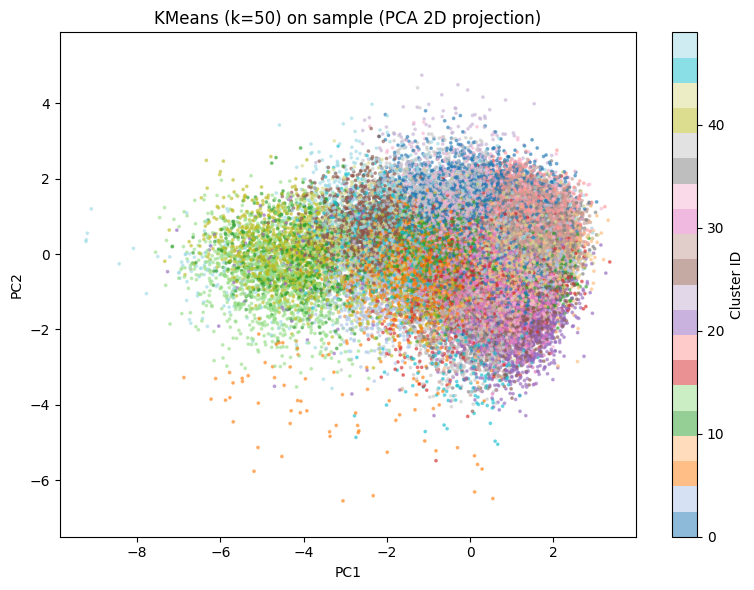

In [12]:
K_VIS = 50  # choose one from k_values
labels_vis = kmeans_labels[K_VIS]

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_pca2_sample[:, 0],
    X_pca2_sample[:, 1],
    c=labels_vis,
    s=3,
    alpha=0.5,
    cmap="tab20",
)
plt.colorbar(scatter, label="Cluster ID")
plt.title(f"KMeans (k={K_VIS}) on sample (PCA 2D projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.ylim(bottom=-7.5)
plt.tight_layout()
plt.show()


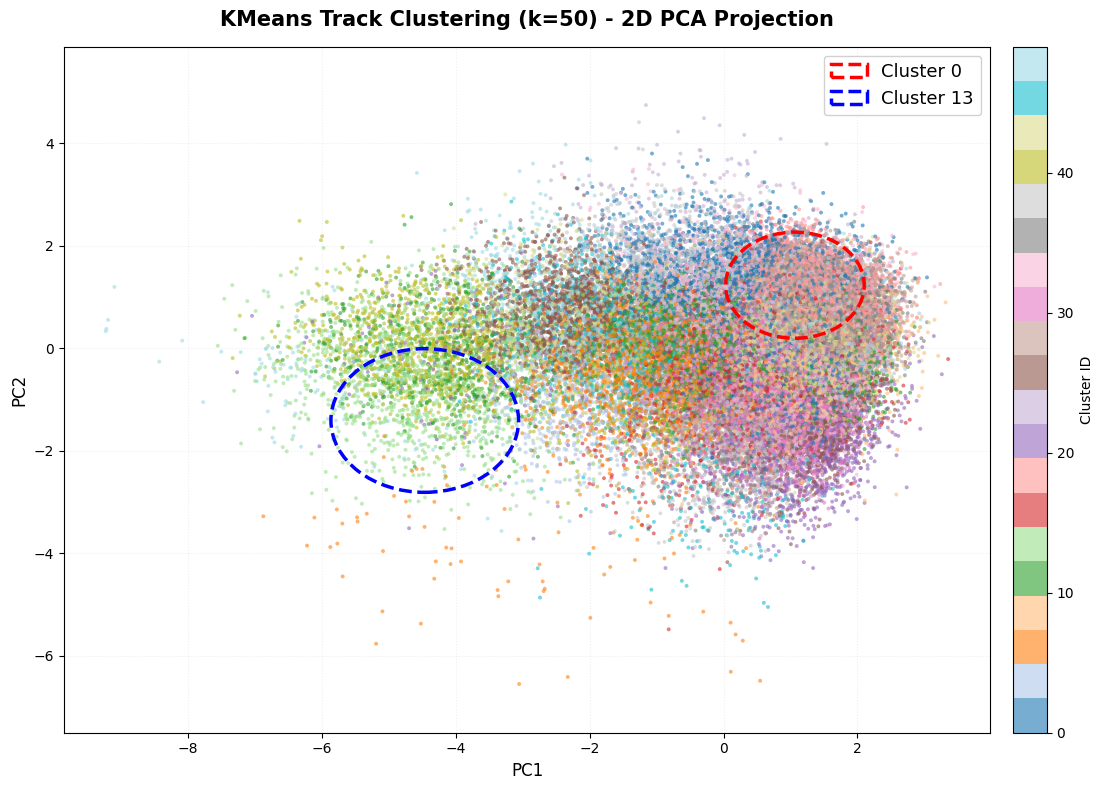

In [42]:
K_VIS = 50  # choose one from k_values
labels_vis = kmeans_labels[K_VIS]

plt.figure(figsize=(12, 8))

# Create scatter plot with better styling
scatter = plt.scatter(
    X_pca2_sample[:, 0],
    X_pca2_sample[:, 1],
    c=labels_vis,
    s=8,
    alpha=0.6,
    cmap="tab20",
    edgecolors='none'
)

# Add circles around clusters 0 and 13
from matplotlib.patches import Circle

for cluster_id, color in [(0, 'red'), (13, 'blue')]:
    # Get points belonging to this cluster
    cluster_mask = labels_vis == cluster_id
    cluster_points = X_pca2_sample[cluster_mask]
    
    if len(cluster_points) > 0:
        # Calculate centroid and radius
        centroid = cluster_points.mean(axis=0)
        distances = np.sqrt(((cluster_points - centroid)**2).sum(axis=1))
        radius = np.percentile(distances, 70)  # 95th percentile for better coverage
        
        # Draw circle
        circle = Circle(
            centroid, 
            radius, 
            fill=False, 
            edgecolor=color, 
            linewidth=2.5, 
            linestyle='--',
            label=f'Cluster {cluster_id}'
        )
        plt.gca().add_patch(circle)

# Styling improvements
plt.colorbar(scatter, label="Cluster ID", pad=0.02)
plt.title(f"KMeans Track Clustering (k={K_VIS}) - 2D PCA Projection", 
          fontsize=15, fontweight='bold', pad=15)
plt.xlabel("PC1", fontsize=12)
plt.ylabel("PC2", fontsize=12)
plt.ylim(bottom=-7.5)
plt.legend(loc='upper right', framealpha=0.9, fontsize=13)
plt.grid(True, alpha=0.2, linestyle=':')
plt.tight_layout()
plt.show()

In [31]:
# Join sample labels back to metadata for inspection
sample_meta = pd.DataFrame({
    "track_id": track_ids_sample
}).merge(
    meta_df_overlap,
    on="track_id",
    how="left"
)

def inspect_kmeans_cluster(k: int, cluster_id: int, n_tracks: int = 20):
    """
    Show example tracks and top artists for a given KMeans cluster.
    """
    if k not in kmeans_labels:
        raise ValueError(f"No KMeans labels for k={k}. Available: {list(kmeans_labels.keys())}")

    labels = kmeans_labels[k]
    mask = labels == cluster_id

    cluster_df = sample_meta[mask].copy()
    print(f"KMeans k={k}, cluster {cluster_id}")
    print(f"  Cluster size: {cluster_df.shape[0]} tracks "
          f"({cluster_df.shape[0] / len(sample_meta) * 100:.2f}% of sample)\n")

    print("Example tracks in this cluster:")
    display(cluster_df[["track_name", "artist_name", "album_name"]].head(n_tracks))

    print("\nTop artists in this cluster:")
    display(
        cluster_df["artist_name"]
        .value_counts()
        .head(10)
        .rename("count")
        .to_frame()
    )
pd.set_option('display.max_rows', None)  # Show all rows


# Example: inspect cluster 0 for k=50
inspect_kmeans_cluster(K_VIS, cluster_id=0, n_tracks=50)


KMeans k=50, cluster 0
  Cluster size: 1213 tracks (2.43% of sample)

Example tracks in this cluster:


,track_name,artist_name,album_name
161,Let’s Ride (feat. Jay Dilla),J. Period,The [Abstract] Best Vol. 1
168,Wake Up,Demotus,No Luck
216,African Herbsman,Bob Marley & The Wailers,The Complete Upsetter Collection
271,7 Letters Coked Out (Intro),Andre Nickatina,Booty Star- Glock Tawk
296,King Nicky's Crown,Andre Nickatina,Daiquiri Factory Cocaine Raps Volume 2
316,Jamaica Nice/Take Me Home Country Roads,Yellowman,King Yellowman
402,Appreciate - Main,Pete Rock,BBE15 - 15 Years Of Real Music For Real People...
410,Notification,Myles Parrish,Notification
446,Mista Busta,Dru Down,Can You Feel Me
488,Movin Backwards,A Tribe Called Quest,We got it from Here... Thank You 4 Your service



Top artists in this cluster:


,count
artist_name,
Nas,10
E-40,9
Lil Wayne,9
OutKast,8
Mac Dre,8
Snoop Dogg,7
Migos,6
Missy Elliott,6
Busta Rhymes,6


In [15]:
N_COMPONENTS_GMM = 20  # tweak as desired

print(f"Fitting GMM with {N_COMPONENTS_GMM} components on {X_pca10_sample.shape[0]} samples...")
gmm = GaussianMixture(
    n_components=N_COMPONENTS_GMM,
    covariance_type="full",
    random_state=RANDOM_SEED,
)
gmm_labels = gmm.fit_predict(X_pca10_sample)
gmm_probs = gmm.predict_proba(X_pca10_sample)

print("GMM fitted.")
print("GMM weights:", gmm.weights_)
print("GMM means shape:", gmm.means_.shape)


Fitting GMM with 20 components on 50000 samples...
GMM fitted.
GMM weights: [0.25789139 0.00650193 0.01417553 0.00274096 0.02439579 0.18508887
 0.10708854 0.0058598  0.00076    0.14366254 0.03960858 0.1535448
 0.0051418  0.00142745 0.00524719 0.00447969 0.0064653  0.00895027
 0.01888676 0.0080828 ]
GMM means shape: (20, 10)


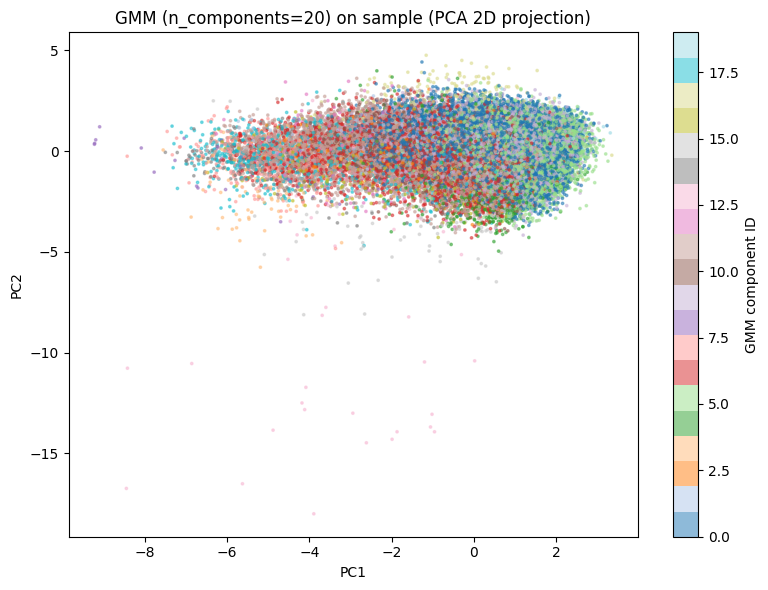

In [16]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_pca2_sample[:, 0],
    X_pca2_sample[:, 1],
    c=gmm_labels,
    s=3,
    alpha=0.5,
    cmap="tab20",
)
plt.colorbar(scatter, label="GMM component ID")
plt.title(f"GMM (n_components={N_COMPONENTS_GMM}) on sample (PCA 2D projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


In [17]:
sample_meta_gmm = sample_meta.copy()
sample_meta_gmm["gmm_component"] = gmm_labels

def inspect_gmm_component(component_id: int, n_tracks: int = 20):
    """
    Show example tracks & artists for a given GMM component.
    """
    mask = sample_meta_gmm["gmm_component"] == component_id
    comp_df = sample_meta_gmm[mask].copy()

    print(f"GMM component {component_id}")
    print(f"  Size: {comp_df.shape[0]} tracks "
          f"({comp_df.shape[0] / len(sample_meta_gmm) * 100:.2f}% of sample)\n")

    print("Example tracks in this component:")
    display(comp_df[["track_name", "artist_name", "album_name"]].head(n_tracks))

    print("\nTop artists in this component:")
    display(
        comp_df["artist_name"]
        .value_counts()
        .head(10)
        .rename("count")
        .to_frame()
    )


inspect_gmm_component(component_id=0, n_tracks=15)


GMM component 0
  Size: 12920 tracks (25.84% of sample)

Example tracks in this component:


,track_name,artist_name,album_name
2,Hollywood,Lissie,My Wild West
5,Son Of A Preacherman,Reggie Young,Soul Summit: Live At The Berks Jazz Fest
6,Fwm,Curly Savv And Dah Dah,First Quarter
7,I Don't Call Him Daddy,Kenny Rogers,I Prefer the Moonlight
8,Calabash,Georgia Anne Muldrow,Seeds
11,Devil at the Wheel,Bill Champlin,Justified (Music from the Original Television ...
13,Bad Chick,Cro,Melodie
15,Cone of Shame,Faith No More,Sol Invictus
19,No Way,Michael Warren,Race To Beat The Sun
20,Circle The Sky,MyChildren MyBride,Unbreakable



Top artists in this component:


,count
artist_name,
Johnny Cash,21
Green Day,19
Frank Sinatra,18
Glee Cast,18
The Beach Boys,17
Gucci Mane,17
George Strait,17
Bob Dylan,15
Kidz Bop Kids,15


In [18]:
def show_gmm_membership_for_index(sample_idx: int, top_n: int = 5):
    """
    Show the top-n most probable GMM components for a given sample index.
    """
    probs = gmm_probs[sample_idx]
    top_comp_ids = np.argsort(probs)[::-1][:top_n]
    print(f"Track: {sample_meta_gmm.iloc[sample_idx]['track_name']} - "
          f"{sample_meta_gmm.iloc[sample_idx]['artist_name']}")
    print("Top GMM components (component_id, prob):")
    for cid in top_comp_ids:
        print(f"  {cid}: {probs[cid]:.3f}")


show_gmm_membership_for_index(sample_idx=0, top_n=5)


Track: There's No Sky - Jaill
Top GMM components (component_id, prob):
  11: 1.000
  4: 0.000
  12: 0.000
  16: 0.000
  15: 0.000


In [19]:
if HDBSCAN_AVAILABLE:
    print("Fitting HDBSCAN on PCA-10 sample...")
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=50,    # tweak as needed
        min_samples=None,
        metric="euclidean",
        core_dist_n_jobs=-1,
    )

    hdb_labels = clusterer.fit_predict(X_pca10_sample)
    print("HDBSCAN fitted.")
    print("Number of clusters (excluding noise):",
          len(set(hdb_labels) - {-1}))

    # Attach labels to metadata
    sample_meta_hdb = sample_meta.copy()
    sample_meta_hdb["hdbscan_label"] = hdb_labels
else:
    print("HDBSCAN not available; skipping this section.")


Fitting HDBSCAN on PCA-10 sample...


c:\Users\Kiera\Music_Recommender\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Kiera\Music_Recommender\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN fitted.
Number of clusters (excluding noise): 2


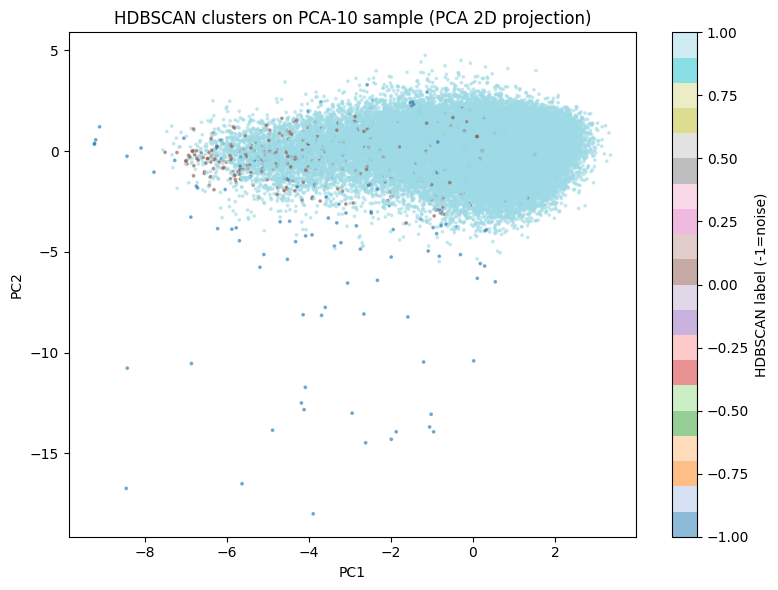

HDBSCAN cluster sizes (label: count):


-1      166
 0      415
 1    49419
Name: count, dtype: int64

In [ ]:
if HDBSCAN_AVAILABLE:
    plt.figure(figsize=(8, 6))
    # Noise as -1, let's map to a separate colour
    unique_labels = np.unique(hdb_labels)
    scatter = plt.scatter(
        X_pca2_sample[:, 0],
        X_pca2_sample[:, 1],
        c=hdb_labels,
        s=3,
        alpha=0.5,
        cmap="tab20",
    )
    plt.colorbar(scatter, label="HDBSCAN label (-1=noise)")
    plt.title("HDBSCAN clusters on PCA-10 sample (PCA 2D projection)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()

    # Cluster size summary
    cluster_counts = pd.Series(hdb_labels).value_counts().sort_index()
    print("HDBSCAN cluster sizes (label: count):")
    display(cluster_counts)


In [ ]:
if HDBSCAN_AVAILABLE:
    def inspect_hdbscan_cluster(label: int, n_tracks: int = 20):
        """
        Inspect tracks and artists in a given HDBSCAN cluster.
        Use label = -1 to inspect noise points.
        """
        mask = sample_meta_hdb["hdbscan_label"] == label
        cluster_df = sample_meta_hdb[mask].copy()

        print(f"HDBSCAN cluster label {label}")
        print(f"  Size: {cluster_df.shape[0]} tracks "
              f"({cluster_df.shape[0] / len(sample_meta_hdb) * 100:.2f}% of sample)\n")

        print("Example tracks in this cluster:")
        display(cluster_df[["track_name", "artist_name", "album_name"]].head(n_tracks))

        print("\nTop artists in this cluster:")
        display(
            cluster_df["artist_name"]
            .value_counts()
            .head(10)
            .rename("count")
            .to_frame()
        )

    # Example: look at first non-noise label
    non_noise_labels = sorted(set(hdb_labels) - {-1}) if HDBSCAN_AVAILABLE else []
    if non_noise_labels:
        inspect_hdbscan_cluster(non_noise_labels[0], n_tracks=15)


HDBSCAN cluster label 0
  Size: 415 tracks (0.83% of sample)

Example tracks in this cluster:


,track_name,artist_name,album_name
39,What a Wonderful World,Jeffrey Michael,"Cinematic Fantasy, Vol. 2"
190,Nobody But You,Kalin and Myles,Chase Dreams
241,El Califa,Antonio Aguilar,15 Exitos Corridos - Antonio Aguilar
675,Sacramento,Kota the Friend,Paloma Beach
793,Ancient Portal,Midnight Syndicate,Monsters of Legend
795,Echoes,Breaking Orbit,The Time Traveller
898,Diamonds,Fabolous,From Nothin' To Somethin'
900,Guarani,Ennio Morricone,The Mission: Music From The Motion Picture
991,"Thème principal (From ""La mort aux trousses"")",The City of Prague Philharmonic Orchestra,Les plus grands thèmes du cinéma: Suspense
1241,"The Four Seasons, Violin Concerto in E Major, ...",Antonio Vivaldi,Vivaldi: The Folk Seasons



Top artists in this cluster:


,count
artist_name,
Chalino Sanchez,4
Frédéric Chopin,3
Glee Cast,3
Midnight Syndicate,3
Johann Sebastian Bach,3
Andrew Holdsworth,2
Red Hot Chili Peppers,2
Alexandre Desplat,2
Rob Gardner,2
